# LOS Prediction - Basic Linear Regression with Regularization

This notebook explores fitting the 24 or 48 hour data set using linear regression with SGD

In [73]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

import numpy as np

print(tf.__version__)

2.0.0


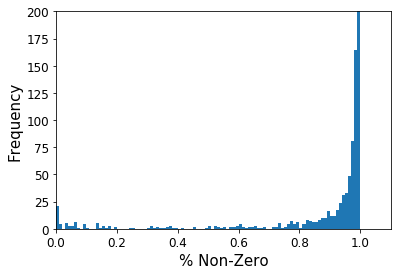

In [74]:
raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.csv', header=0)
df = raw_dataset.copy()

# Plot how many columns have non-zero values
(df==0).mean().hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("% Non-Zero", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,1.1])
plt.ylim([0,200.0])

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)


In [75]:

print("Num columns starting: " + str(len(df.columns)))

df = df.loc[:, (df==0).mean() < .9]
df.fillna(0, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Heart Rate'] > 0]

# Remove outliers
df = df[df['los'] <= 100]

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


Num columns starting: 2474


,status,los,age,gender,insurance,language,religion,marital_status,ethnicity,Anion Gap,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3877,1,4.790,76.5246,F,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,13.538,...,116.111,0.244,0.000,0.000,15.260,0.075,34.875,-0.358,99.706,0.022
3878,0,1.313,55.9574,M,Private,ENGL,NOT SPECIFIED,SEPARATED,WHITE,15.333,...,140.000,0.386,2.571,-0.094,59.429,0.405,36.565,-0.048,0.000,0.000
3879,0,36.052,74.4794,M,Medicare,ENGL,CATHOLIC,MARRIED,OTHER,12.000,...,132.000,21.201,3.833,-0.179,14.900,0.049,0.000,0.000,96.381,0.097
3880,0,5.001,46.7991,M,Private,ENGL,NOT SPECIFIED,MARRIED,BLACK/AFRICAN AMERICAN,16.000,...,124.280,-0.632,4.000,-0.000,22.346,-0.071,0.000,0.000,98.000,0.015
3881,0,9.067,28.4195,F,Private,PTUN,UNOBTAINABLE,MARRIED,WHITE,11.750,...,153.455,0.750,10.000,-0.000,17.089,-0.246,0.000,0.000,96.222,0.010


In [76]:
# One hot encode the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    df = df.join(one_hot)

df = df.loc[:, (df==0).mean() < .9]

In [77]:
los = df.pop('los')

# NORMALIZE THE DATASET
stats = df.describe()
stats = stats.transpose()

def norm(x):
  return (x - stats['mean']) / stats['std']
normed_df = norm(df)

print("Num columns before feature selection: " + str(len(normed_df.columns)))


Num columns before feature selection: 236


In [78]:

# DIVIDE INTO TRAIN/TEST
normed_df.insert(0, 'los', los)
train_dataset = normed_df.sample(frac=0.7)
test_dataset = normed_df.drop(train_dataset.index)
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')


10.655549201442554
7.9725


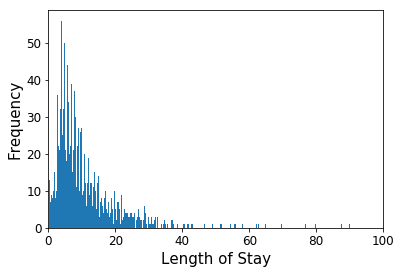

In [79]:
# LOS histogram

normed_df['los'].hist(bins=1000, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Length of Stay", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,100.0])

print(normed_df['los'].mean())
print(normed_df['los'].median())


In [80]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet
from math import sqrt, isfinite

X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)
# normed_train_data

def train_and_print_stats(clf):
    clf.fit(X_train, y_train)

    y_train_preds = clf.predict(X_train)
    training_error = mean_absolute_error(y_train, y_train_preds)
    #print("Training (LOS): " + str(training_error))

    y_val_preds = clf.predict(X_val)
    val_error = mean_absolute_error(y_val, y_val_preds)

    y_test_preds = clf.predict(test_dataset)
    test_error = mean_absolute_error(test_labels, y_test_preds)
    
    print(str(round(training_error, 3)) + "," + str(round(val_error, 3)) + "," + str(round(test_error, 3)))

#print("Linear Regression: ")
clf = LinearRegression(normalize=False)
train_and_print_stats(clf)

#print("SGD Regression (L1): ")
clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.001)
train_and_print_stats(clf)

#print("SGD Regression (L2): ")
clf = SGDRegressor(loss="squared_loss", penalty="l2", eta0=0.001)
train_and_print_stats(clf)

#print("Elastic Net: ")
clf = ElasticNet(l1_ratio=0.5, max_iter=10000)
train_and_print_stats(clf)



5.226,8.519,8.788
5.334,6.873,7.308
5.331,6.905,7.344
6.143,5.761,5.897


In [81]:
#np.subtract(y_train_preds, y_train)
#sns.residplot(y_train, np.subtract(y_train_preds, y_train), lowess=True, color="g")

ax = sns.residplot(test_labels, np.subtract(y_test_preds, test_labels), lowess=True, color="g")
ax.set(xlabel='Actual Length of Stay', ylabel='Residual')
plt.show()

ValueError: operands could not be broadcast together with shapes (1089,) (1165,) 